In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
import numpy as np
import scipy 
import scipy.stats
from scipy import stats
import iminuit
from iminuit import Minuit

mpl.rcParams['font.size'] = 18      # Set the general plotting font size
plt.rc("font", family="serif")
#plt.rc("text", usetex=True)

save_plots = False
fit_to_latest = False

In [2]:

# Print how much data is included:
date_start = "2021-01-01"            # This is thus day 0
if fit_to_latest :
    date_end = data_test.index[-3]   # Omitting the very latest data point (with ~0 statistics)
else :
    date_end = "2021-03-09"          # Value in latest report files
print("  Data used: ", date_start, "-", date_end)    

filepath = "../PrivateData/PrivateData090321.txt" #In a seperate folder for now, subject to change

with open(filepath, 'r') as data: #Pretty messy code, could be changed with better inputs
    lines = data.readlines()
    n = len(lines)
    Np_AG = np.zeros(n)
    Nt_AG = np.zeros(n)
    Np_PCR = np.zeros(n)
    Nt_PCR = np.zeros(n)
    days = np.zeros(n, dtype=object)
    for index, line in enumerate(lines):
        x = line.split()
        days[index] = x[0].replace('.','-') #Changing separators
        days[index] = days[index][6:] + '-' + days[index][3:5] + '-' + days[index][:2] #Converting into right format
        Nt_AG[index] = float(x[5].replace('.',''))#Removing separators if they exist
        Np_AG[index] = float(x[6].replace('.',''))
        Nt_PCR[index] = float(x[2].replace('.',''))
        Np_PCR[index] = float(x[3].replace('.',''))

all_data = pd.DataFrame(np.array([days, Nt_AG, Np_AG, Nt_PCR, Np_PCR]).T, columns=['Day', 'Nt_AG', 'Np_AG', 'Nt_PCR', 'Np_PCR'])
#Have to assert this or some calculations do not work
all_data = all_data.astype({'Day': 'datetime64', 'Nt_AG': 'int64', 'Nt_PCR': 'int64', 'Np_AG': 'int64', 'Np_PCR': 'int64'}) 
all_data = all_data.set_index('Day')
    
P_AG = np.flip(all_data["Np_AG"][date_end:date_start])
eP_AG = np.sqrt(P_AG)
N_AG = np.flip(all_data["Nt_AG"][date_end:date_start])
eN_AG = np.sqrt(N_AG)
P_PCR = np.flip(all_data["Np_PCR"][date_end:date_start])
eP_PCR = np.sqrt(P_PCR)
N_PCR = np.flip(all_data["Nt_PCR"][date_end:date_start])
eN_PCR = np.sqrt(N_PCR)
day  = np.arange(1,len(P_AG)+1)

# Number of positive tests and uncertainty, assuming fixed number of daily tests and power law correction:
Power = 0.56         # Power in power law for the increase in positives with increase in tests.
# SystError = 0.000   # To account for larger uncertainties on fraction positives than simply the statistical.

# TP 6. March: Are the above necessary? And the below scaling (yet)?
# TP 8. March: Better naming of....  P -> SP -> SCP

nAveDailyTests_AG = N_AG.mean()
nAveDailyTests_PCR = N_PCR.mean()
print("Average number of AntiGen tests: ", nAveDailyTests_AG)
print("Average number of PCR tests: ", nAveDailyTests_PCR)
fPos_AG = P_AG / N_AG
SP_AG  = P_AG * (N_AG / nAveDailyTests_AG)**(-Power)
eSP_AG = (N_AG*fPos_AG*(1-fPos_AG) ) ** 0.5 * (N_AG / nAveDailyTests_AG)**(-Power)
fPos_PCR = P_PCR / N_PCR
SP_PCR  = P_PCR * (N_PCR / nAveDailyTests_PCR)**(-Power)
eSP_PCR = (N_PCR*fPos_PCR*(1-fPos_PCR) ) ** 0.5 * (N_PCR / nAveDailyTests_PCR)**(-Power)


# Print the data used for fits:
print(" Date      Ntest_AG      Nposi_AG (P)    SP_AG ")
for i in range(len(P_AG)) :
    print(f"{i+1:4d}   {N_AG[i]:10d}    {P_AG[i]:8d}       {SP_AG[i]:8.0f}")

  Data used:  2021-01-01 - 2021-03-09
Average number of AntiGen tests:  28583.567164179105
Average number of PCR tests:  1193.5373134328358
 Date      Ntest_AG      Nposi_AG (P)    SP_AG 
   1         9562         321            593
   2        18282         443            569
   3        26152         491            516
   4        32978         453            418
   5        23099         351            395
   6        19627         303            374
   7        18953         216            272
   8        18885         248            313
   9        14745         171            248
  10        14251         202            298
  11        22198         261            301
  12        15325         229            325
  13        16666         183            248
  14        26777         214            222
  15        29653         182            178
  16        20707         148            177
  17        20733         142            170
  18        26147         159            167
  

In [3]:
# Average time between generations (in days):
tG = 4.7

# Fitting function for fraction B117:
t0_B117fit  = 35.0        # t0 is 2021-02-04
frac_t0     = 0.255       # +- 0.008   
tau_B117    = 12.19       # +- 0.40
factor_B117 = np.e**(tG/tau_B117)     # = 1.47. Thus B117 is a factor 1.47 more infectious

def func_fB117(t, frac_t0, tau) :
    return frac_t0*np.exp((t-t0_B117fit)/tau) / ((1-frac_t0) + frac_t0*np.exp((t-t0_B117fit)/tau))

In [4]:
dt.datetime.strptime(date_end,'%Y-%m-%d')#Converting to datetime
days_to_fit = np.arange((dt.datetime.strptime(date_end,'%Y-%m-%d')-dt.datetime.strptime(date_start,'%Y-%m-%d')).days)#Make list for fitting

In [14]:
def func_DoubleExpoStepW(x, N0, Rb, Ra, t0, fW, tW, sW, tG) :
    FracB117_at_t0 = func_fB117(t0_B117fit, frac_t0, tau_B117)       # Get B117 fraction at t0_B117fit (=4.Feb.2021)
    FactorW = 1.0 + fW/(1.0 + np.exp(-(x-tW)/sW))
    if (x < t0) :
        return N0 * FactorW * ((1.0-FracB117_at_t0) * Rb**((x-t0)/tG) + FracB117_at_t0 * (Rb * factor_B117)**((x-t0)/tG))
    else :
        return N0 * FactorW * ((1.0-FracB117_at_t0) * Ra**((x-t0)/tG) + FracB117_at_t0 * (Ra * factor_B117)**((x-t0)/tG))

func_DoubleExpoStepW_vec = np.vectorize(func_DoubleExpoStepW)

# The DK component of the above function:
def func_StepRDK(x, N0, Rb, Ra, t0, tG) :
    FracB117_at_t0 = func_fB117(t0_B117fit, frac_t0, tau_B117)       # Get B117 fraction at t0_B117fit (=4.Feb.2021)
    if (x < t0) :
        return N0 * ((1.0-FracB117_at_t0) * Rb**((x-t0)/tG))
    else :
        return N0 * ((1.0-FracB117_at_t0) * Ra**((x-t0)/tG))
func_StepRDK_vec = np.vectorize(func_StepRDK)

# The UK B117 component of the above function:
def func_StepRB117(x, N0, Rb, Ra, t0, tG):
    FracB117_at_t0 = func_fB117(t0_B117fit, frac_t0, tau_B117)       # Get B117 fraction at t0_B117fit (=4.Feb.2021)
    if (x < t0) :
        return N0 * FracB117_at_t0 * (Rb * factor_B117)**((x-t0)/tG)
    else :
        return N0 * FracB117_at_t0 * (Ra * factor_B117)**((x-t0)/tG)
func_StepRB117_vec = np.vectorize(func_StepRB117)

# ChiSquare fit model:
def chi2_calcStepW(N0, Rb, Ra, t0, fW, tW, sW, tG) :
    y_fit = func_DoubleExpoStepW_vec(days_to_fit, N0, Rb, Ra, t0, fW, tW, sW, tG)
    chi2 = np.sum(((SP_AG - y_fit) / eSP_AG)**2)
    return chi2
minuit3w = Minuit(chi2_calcStepW, N0=40.0, Rb=0.7, Ra=0.7, t0=28.0, fix_t0=False, fW=0.5, tW=48.0, sW=0.5, fix_sW=True, tG=4.7, fix_tG=True, fix_tW=True, print_level=1, errordef=1.0)
minuit3w.migrad();

# Here we extract the fitting parameters and their errors
N0_fit3w = minuit3w.values['N0'];       sigma_N0_fit3w = minuit3w.errors['N0']
Rb_fit3w = minuit3w.values['Rb'];       sigma_Rb_fit3w = minuit3w.errors['Rb']
Ra_fit3w = minuit3w.values['Ra'];       sigma_Ra_fit3w = minuit3w.errors['Ra']
t0_fit3w = minuit3w.values['t0'];       sigma_t0_fit3w = minuit3w.errors['t0']
fW_fit3w = minuit3w.values['fW'];       sigma_fW_fit3w = minuit3w.errors['fW']
tW_fit3w = minuit3w.values['tW'];       sigma_tW_fit3w = minuit3w.errors['tW']
sW_fit3w = minuit3w.values['sW'];       sigma_sW_fit3w = minuit3w.errors['sW']
print("  N0 fit = ", N0_fit3w, "+-", sigma_N0_fit3w)
print("  Rb fit = ", Rb_fit3w, "+-", sigma_Rb_fit3w)
print("  Ra fit = ", Ra_fit3w, "+-", sigma_Ra_fit3w)
print("  t0 fit = ", t0_fit3w, "+-", sigma_t0_fit3w)
print("  fW fit = ", fW_fit3w, "+-", sigma_fW_fit3w)
print("  tW fit = ", tW_fit3w, "+-", sigma_tW_fit3w)
# print("  sW fit = ", sW_fit3w, "+-", sigma_sW_fit3w)

# Calcuate fit quality:
Chi2_fit2 = minuit3w.fval       # The Chi2 value
Nvar = 5                       # Number of variables (tG is fixed!)
Ndof_fit2 = len(days_to_fit) - Nvar     # Number of degrees of freedom = Number of data points - Number of variables
Prob_fit2 = stats.chi2.sf(Chi2_fit2, Ndof_fit2)    # The chi2 probability given N degrees of freedom    
print(f"  Prob(Chi2={Chi2_fit2:5.1f}, Ndof={Ndof_fit2:2d}) = {Prob_fit2:5.3f}")

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 253.8                      │        Nfcn = 322 (322 total)        │
│ EDM = 1.7e-05 (Goal: 0.0002)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
  N0 fit =  61.980112443327734 +- 3.0738834244672626
  Rb fit =  0.7154706172799453 +- 0.005895026124528551
  Ra fit =  0.891297268001462 +- 0.021853355316276704
  t0 fit =  34.10181761391633 +- 1.114655661111049
  fW fit =  0.1385774263364

In [6]:
def func_DoubleExpoStep2(x, N0, Rb, Ra, Rc, t0, t1, tG) :
    FracB117_at_t0 = func_fB117(t0_B117fit, frac_t0, tau_B117)       # Get B117 fraction at t0_B117fit (=4.Feb.2021)
    if (x < t0) :
        return N0 * ((1.0-FracB117_at_t0) * Rb**((x-t0)/tG) + FracB117_at_t0 * (Rb * factor_B117)**((x-t0)/tG))
    elif (x < t1) :
        return N0 * ((1.0-FracB117_at_t0) * Ra**((x-t0)/tG) + FracB117_at_t0 * (Ra * factor_B117)**((x-t0)/tG))
    else :
        N1 = N0 * ((1.0-FracB117_at_t0) * Ra**((t1-t0)/tG) + FracB117_at_t0 * (Ra * factor_B117)**((t1-t0)/tG))
        return N1 * ((1.0-FracB117_at_t0) * Rc**((x-t1)/tG) + FracB117_at_t0 * (Rc * factor_B117)**((x-t1)/tG))

func_DoubleExpoStep2_vec = np.vectorize(func_DoubleExpoStep2)

# ChiSquare fit model:
def chi2_calcStep2(N0, Rb, Ra, Rc, t0, t1, tG) :
    y_fit = func_DoubleExpoStep2_vec(days_to_fit, N0, Rb, Ra, Rc, t0, t1, tG)
    chi2 = np.sum(((SP_AG - y_fit) / eSP_AG)**2)
    return chi2

# The t0 is now just set to the end of the B117-fit... it should of course not be... To Be Changed/Updated!
minuit4 = Minuit(chi2_calcStep2, N0=40.0, Rb=0.7, Ra=0.8, Rc=0.9, t0=37.0, fix_t0=False, t1=42.0, fix_t1=True, tG=4.7, fix_tG=True, print_level=1, errordef=1.0)
minuit4.migrad();                                                  

# Here we extract the fitting parameters and their errors
N0_fit4 = minuit4.values['N0'];       sigma_N0_fit4 = minuit4.errors['N0']
Rb_fit4 = minuit4.values['Rb'];       sigma_Rb_fit4 = minuit4.errors['Rb']
Ra_fit4 = minuit4.values['Ra'];       sigma_Ra_fit4 = minuit4.errors['Ra']
Rc_fit4 = minuit4.values['Rc'];       sigma_Rc_fit4 = minuit4.errors['Rc']
t0_fit4 = minuit4.values['t0'];       sigma_t0_fit4 = minuit4.errors['t0']
t1_fit4 = minuit4.values['t1'];       sigma_t1_fit4 = minuit4.errors['t1']
print("  N0 fit = ", N0_fit4, "+-", sigma_N0_fit4)
print("  Rb fit = ", Rb_fit4, "+-", sigma_Rb_fit4)
print("  Ra fit = ", Ra_fit4, "+-", sigma_Ra_fit4)
print("  Rc fit = ", Rc_fit4, "+-", sigma_Rc_fit4)
print("  t0 fit = ", t0_fit4, "+-", sigma_t0_fit4)
print("  t1 fit = ", t1_fit4, "+-", sigma_t1_fit4)

# Calcuate fit quality:
Chi2_fit2 = minuit4.fval       # The Chi2 value
Nvar = 3                       # Number of variables (tG is fixed!)
Ndof_fit2 = len(days_to_fit) - Nvar     # Number of degrees of freedom = Number of data points - Number of variables
Prob_fit2 = stats.chi2.sf(Chi2_fit2, Ndof_fit2)    # The chi2 probability given N degrees of freedom    
print(f"  Prob(Chi2={Chi2_fit2:5.1f}, Ndof={Ndof_fit2:2d}) = {Prob_fit2:5.3f}")

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 259.5                      │        Nfcn = 441 (441 total)        │
│ EDM = 4.42e-06 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
  N0 fit =  46.83904388835083 +- 2.2645289380000384
  Rb fit =  0.7270905144331358 +- 0.0046908172442022165
  Ra fit =  1.9979520807334719 +- 0.744420409843781
  Rc fit =  0.9564814736695667 +- 0.011949329022498923
  t0 fit =  39.7892275368

[]

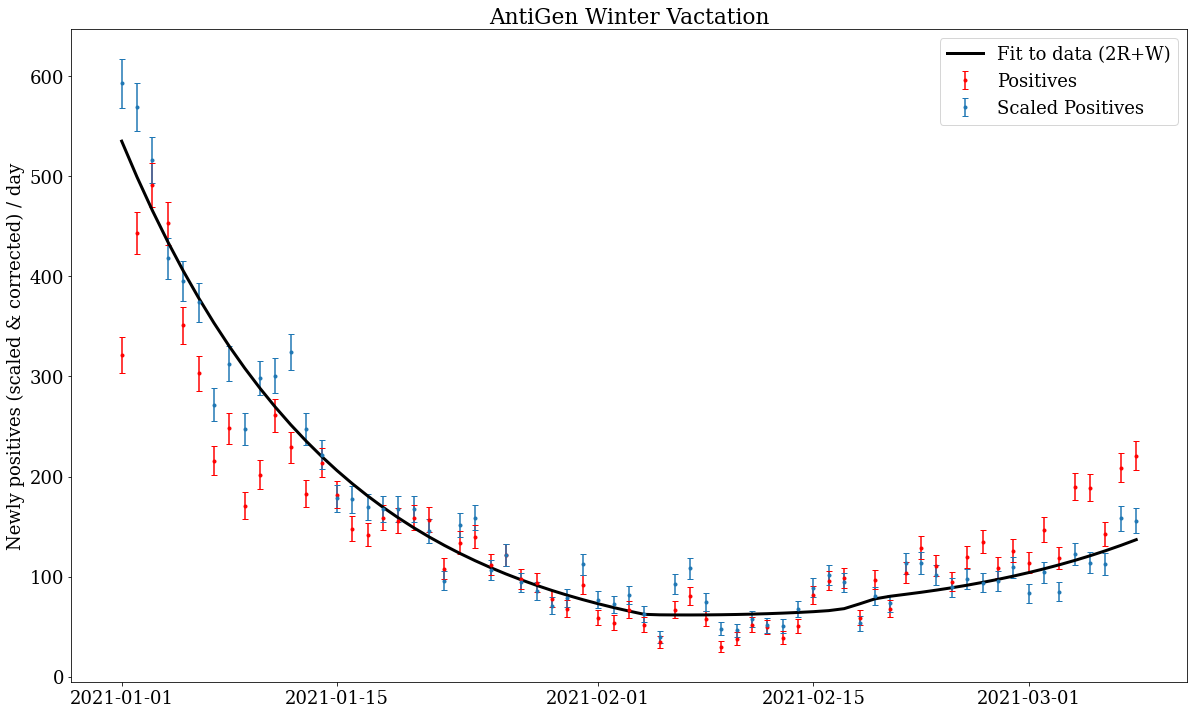

In [15]:
fig, ax = plt.subplots(figsize=(20, 12))
ax.set(xlabel="", ylabel="Newly positives (scaled & corrected) / day", title="AntiGen Winter Vactation")
ax.errorbar(P_AG.index, P_AG[date_start:date_end], yerr = np.sqrt(P_AG[date_start:date_end]), fmt='.', capsize=3, label='Positives', color='red')
ax.errorbar(SP_AG.index, SP_AG[date_start:date_end], yerr = np.sqrt(SP_AG[date_start:date_end]), fmt='.', capsize=3, label='Scaled Positives')
ax.plot(P_AG.index,    func_DoubleExpoStepW_vec(days_to_fit,  N0_fit3w, Rb_fit3w, Ra_fit3w, t0_fit3w, fW_fit3w, tW_fit3w, sW_fit3w, tG), 'black', linewidth=3.0, label='Fit to data (2R+W)')
ax.legend(loc='best')
plt.plot()